In [34]:
import os
from dotenv import load_dotenv
import psycopg2
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import networkx as nx
from networkx.algorithms.community import girvan_newman, louvain_communities
import matplotlib.pyplot as plt

# Load environment variables from .env file
load_dotenv()

# Accessing the environment variables
database = os.getenv('DATABASE')
database_user = os.getenv('DATABASE_USER')
database_password = os.getenv('DATABASE_PASSWORD')
database_host = os.getenv('DATABASE_HOST')
database_port = os.getenv('DATABASE_PORT')

In [22]:
try:
    connection = psycopg2.connect(
        database=database, 
        user=database_user, 
        password=database_password, 
        host=database_host, 
        port=database_port
    )

    cursor = connection.cursor()
    # get the largest group of comments on a document currently in database for sample work
    query = "SELECT id, comment FROM regulations_comment WHERE document_id = (SELECT document_id from regulations_comment GROUP BY document_id ORDER BY COUNT(*) DESC LIMIT 1);"
    cursor.execute(query)
    results = cursor.fetchall()

except (Exception, psycopg2.Error) as error:
    print("Error while connecting to PostgreSQL", error)
    
finally:
# Close the connection and cursor to free resources
    if connection:
        cursor.close()
        connection.close()
        print("PostgreSQL connection is closed")

PostgreSQL connection is closed


In [25]:
df = pd.DataFrame(results, columns=['id','comment'])

In [30]:
model = SentenceTransformer("all-mpnet-base-v2")
paraphrases = util.paraphrase_mining(model, list(df['comment']), show_progress_bar=True)

Batches:   0%|          | 0/35 [00:00<?, ?it/s]

In [32]:
def build_graph(data):
    G = nx.Graph()
    for score, id1, id2 in data:
        G.add_edge(id1, id2, weight=score)
    return G

def find_most_central_node_in_clusters(G, clusters):
    centrality_per_cluster = {}
    for cluster in clusters:
        subgraph = G.subgraph(cluster)
        # Using degree centrality for simplicity; you can change this metric
        centralities = nx.degree_centrality(subgraph)
        # Find the node with the highest centrality
        most_central_node = max(centralities, key=centralities.get)
        centrality_per_cluster[most_central_node] = centralities[most_central_node]
    return centrality_per_cluster

In [35]:
# Build graph from data
G = build_graph(paraphrases)

In [36]:
# build communities
louvain_communities_c = louvain_communities(G=G)

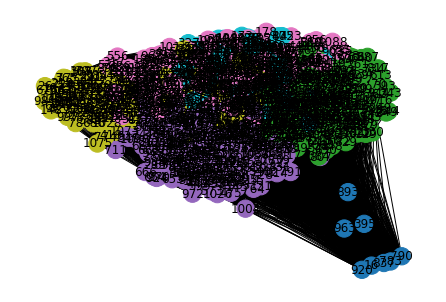

In [37]:
# Create a color map from node to community
community_color = {}
for i, community in enumerate(louvain_communities_c):
    for node in community:
        community_color[node] = i  # Assign a community index as color

# Convert community indices to a color palette in matplotlib
colors = [community_color[node] for node in G.nodes()]

# Draw the graph
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw(G, pos, node_color=colors, with_labels=True, cmap=plt.cm.tab10, node_size=300)

# Show the plot
plt.show()

In [38]:
central_nodes = find_most_central_node_in_clusters(G, louvain_communities_c)

In [41]:
for i,community in enumerate(louvain_communities_c):
    community_size = len(community)
    central_node = list(central_nodes.keys())[i]
    print(f"{community_size} comments represented by comment {central_node}: {results[central_node][1]}")

8 comments represented by comment 963: See attached file
290 comments represented by comment 237: The ADHD drug &quot;shortage&quot; is beyond out of control at this point, as is the way those with ADHD are treated by pharmacists and others in the pharmacy community. We are tired of being treated like drug-seeking addicts every time we go to a pharmacy to fill a prescription (which was written by a clinician to treat our very real and diagnosed disorder), or every time we call a pharmacy just to see if they even have the stock available to fill our prescription since the shortage has gotten so out of control. How can every single pharmacy in a town, be it a &quot;mom and pop&quot; small pharmacy or a big chain like CVS or Walgreens, be out of and unable to get, ANY ADHD medication? How are we STILL, at two years now, on a shortage of both brand and generic Adderall, Vyvanse, Ritalin, etc. Vyvanse just went generic in August and it is now even harder to get; harder than it ever was befo

In [42]:
df_paraphrases = pd.DataFrame(paraphrases, columns = ['similarity', 'c1', 'c2'])

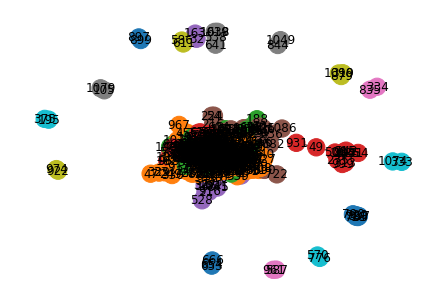

In [73]:
# CDO heuristic is .85 as a threshold for considering comments similar
# Build graph from data
df_cdo = df_paraphrases.loc[df_paraphrases.loc[:,'similarity'] >= .85,:].copy()
data_cdo = [tuple(row) for row in df_cdo.itertuples(index=False, name=None)]
G_cdo = build_graph(data_cdo)
louvain_communities_cdo = louvain_communities(G=G_cdo)
# Create a color map from node to community
community_color = {}
for i, community in enumerate(louvain_communities_cdo):
    for node in community:
        community_color[node] = i  # Assign a community index as color

# Convert community indices to a color palette in matplotlib
colors = [community_color[node] for node in G_cdo.nodes()]

# Draw the graph
pos = nx.spring_layout(G_cdo)  # positions for all nodes
nx.draw(G_cdo, pos, node_color=colors, with_labels=True, cmap=plt.cm.tab10, node_size=300)

# Show the plot
plt.show()

In [79]:
central_nodes_cdo = find_most_central_node_in_clusters(G_cdo, louvain_communities_cdo)
for i,community in enumerate(louvain_communities_cdo):
    community_size = len(community)
    central_node = list(central_nodes_cdo.keys())[i]
    print(f"{community_size} comments represented by comment {central_node}: {results[central_node][1]}")

2 comments represented by comment 897: As a chronic pain patient who uses opiate medications to support a healthy lifestyle, work life &amp; overall quality of life, I have been subjected to delays and reduced available doses of necessary medication. I have also been luckier than others I know. Since opiate scripts are not and mainly never have been a cause of the overall &ldquo;opiate crisis&rdquo; here in the U.S., the lack of life saving and QOL-protecting medications is an enormous, troubling and wholly avoidable source of stress each month - which I need to reduce- if our supplies could be regulated more effectively. It would be helpful to understand the chain supply issues etc better and to know when this may be expected to end. We are suffering enough. Please help us! Thank you! 
5 comments represented by comment 837: See attached file(s)
3 comments represented by comment 666: <br/><br/>* Remove non-compete for physicians (maybe all healthcare workers); they only act to increase

In [78]:
df_cdo.head()

,similarity,c1,c2
0,1.0,897,899
1,1.0,16,783
2,1.0,16,790
3,1.0,16,837
4,1.0,16,920
